# Lab 7: Non-negative decompositions for music processing

Guest lab by J.J. Burred. jjburred@berkeley.edu

In this first part of the lab, we will experiment with decomposing sound spectrograms with **Principal Component Analysis (PCA)** and **Non-Negative Matrix Factorization (NMF)**, and we will create sound layers and synthesize cross-components via **Wiener filtering**.

First, run this preliminary code to import the main utilities and load samples:

In [257]:
!pip install librosa
!pip install matplotlib
!pip install scikit-learn

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import librosa
from pathlib import Path
import ipywidgets as widgets
from IPython.display import Audio, display, clear_output

SAMPLES_PATH = Path('./samples')

sample_list = [str(file.name) for file in Path('./samples').iterdir() if file.is_file()]

sample_dropdown = widgets.Dropdown(
    options=sample_list,
    description="Sample:"
)

# Create a button widget
button = widgets.Button(description="Load")

# Create an Output widget to display the generated music
output_widget = widgets.Output()

# Define a function to be called when the button is clicked
def on_button_click(b):
    with output_widget:
        global y, sr
        clear_output(wait=True)  # Clear the output widget without clearing the dropdowns
        path = Path('./samples') / sample_dropdown.value
        y, sr = librosa.load(path, mono=True, sr=None)
        plt.figure(figsize=(10,2))
        plt.plot(y)
        plt.show()
        display(Audio(y, rate=sr))

# Attach the function to the button's click event
button.on_click(on_button_click)

# Display the widgets and button
widgets.VBox([sample_dropdown, button, output_widget])

You should consider upgrading via the '/Users/jjb/Documents/projects/CNMAT/teaching/music30/nov1_lab/code/env_jj_music30/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/jjb/Documents/projects/CNMAT/teaching/music30/nov1_lab/code/env_jj_music30/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/jjb/Documents/projects/CNMAT/teaching/music30/nov1_lab/code/env_jj_music30/bin/python3 -m pip install --upgrade pip' command.


## Section 1: Principal Component Analysis of spectrograms

We will first compute and display the magnitude spectrogram of the loaded sound.

Start by loading the `toy_target.wav` sound. 

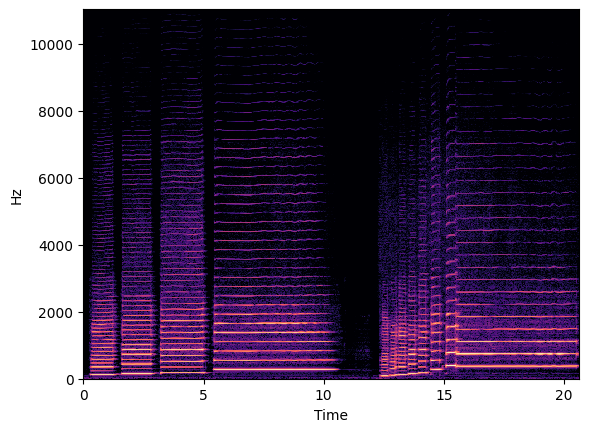

In [259]:
spec = librosa.stft(y)      # short-time Fourier transform
mag_spec = np.abs(spec)
librosa.display.specshow(librosa.amplitude_to_db(mag_spec, ref=np.max), x_axis='time', y_axis='linear')

Now that we have a real-valued input matrix, let's perform a PCA decomposition on it. We will use the `decomposition` library from `scikit-learn`. We need to previously set the desired number of components for the reconstruction. 

Scikit-learn uses the same pipeline for all machine larning models (factorizations, clusterings, neural networks...):

1. Declare the model with the corresponding parameters.
2. Fit the model to the data (a.k.a learning) with the `fit` method.
3. If desired, transform the model with the data with the `transform` method.

In [260]:
n_components = 3

from sklearn.decomposition import PCA 

# declare the model
model = PCA(n_components=n_components, svd_solver='full')

# learn (= fit model to data)
model.fit(mag_spec)

# transform data with the model
bases = model.transform(mag_spec)

# retrieve the activations
acts = model.components_

Alternatively, in most models it is possible to combine learning and transformation into a single method call:

In [261]:
bases = model.fit_transform(mag_spec)

Here is some code to plot the bases and activations aligned with the spectrogram

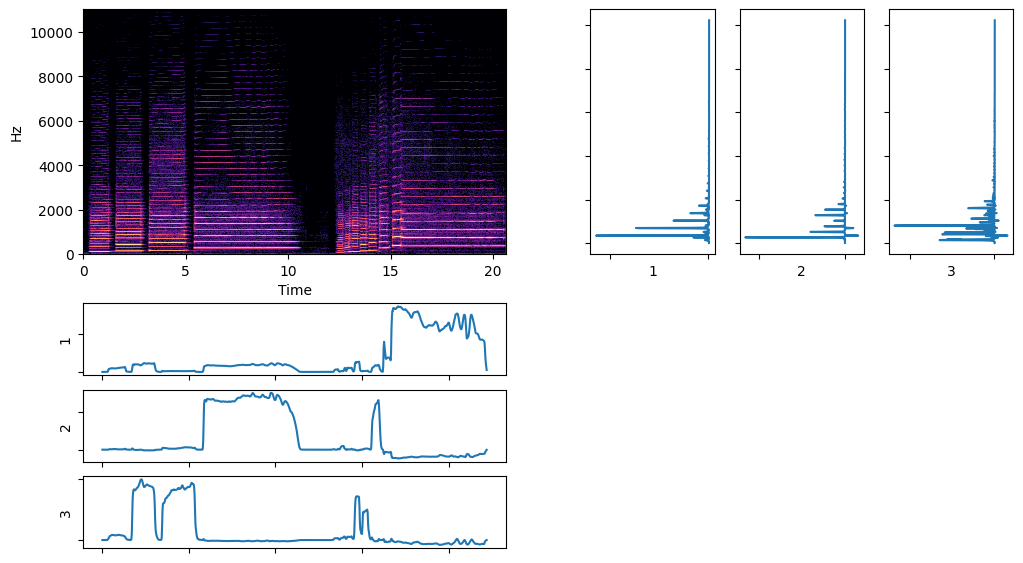

In [262]:
def display_components(in_matrix, bases, acts, n_components=3):

    fig = plt.figure(figsize=(12,7))
    outer_grid = gridspec.GridSpec(2,2, wspace=0.2, hspace=0.2)
    ax_outer = []
    ax_outer.append(fig.add_subplot(outer_grid[0]))
    inner_grid_act = gridspec.GridSpecFromSubplotSpec(1, n_components, subplot_spec=outer_grid[1], wspace=0.2, hspace=0.2)
    ax_base = []
    for i in range(n_components):
        ax_base.append(fig.add_subplot(inner_grid_act[i]))
    inner_grid_base = gridspec.GridSpecFromSubplotSpec(n_components, 1, subplot_spec=outer_grid[2], wspace=0.2, hspace=0.2)
    ax_act = []
    for i in range(n_components):
        ax_act.append(fig.add_subplot(inner_grid_base[i]))
    
    ax_outer[0].clear()
    librosa.display.specshow(librosa.amplitude_to_db(in_matrix, ref=np.max), x_axis='time', y_axis='linear', ax = ax_outer[0])
    
    for c in range(n_components):
        ax_act[c].plot(acts[c,:])
        ax_act[c].set_ylabel(str(c+1))
        ax_act[c].xaxis.set_tick_params(labelbottom=False)
        ax_act[c].yaxis.set_tick_params(labelleft=False)
        ax_base[c].plot(-bases[:,c],np.arange(bases.shape[0]))
        ax_base[c].set_xlabel(str(c+1))
        ax_base[c].xaxis.set_tick_params(labelbottom=False)
        ax_base[c].yaxis.set_tick_params(labelleft=False)

display_components(mag_spec, bases, acts, n_components)

## Section 2: Non-negative Matrix Factorization of spectrograms

Let's redo a spectrogram decomposition, but this time with NMF:

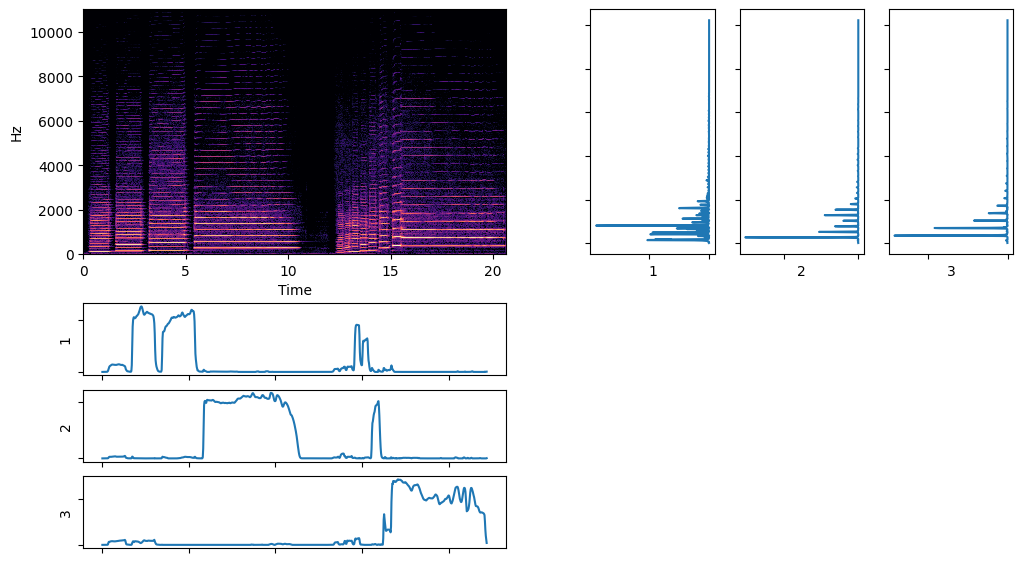

In [263]:
n_components = 3

from sklearn.decomposition import NMF
model = NMF(n_components=n_components, init='random', solver='mu')
bases = model.fit_transform(mag_spec)
acts = model.components_

display_components(mag_spec, bases, acts, n_components)

Is it any better than PCA, in terms of interpretable temporal/spectral information from the components? Hopefully yes, but it seems the white noise bursts are not captured very well. Why?

By default, the scikit-learn implementation of NMF uses the **Frobenius norm** as cost function. The Frobenius norm is the matrix equivalent of the Euclidean distance (related to the Mean Squared Error), which is not very perceptually relevant. On the other hand, the **Kullback-Leibler (KL) divergence** encourages sparsity of the components (spectra with individual harmonics/partials) and is more robust to noise.

So, let's try the KL divergence instead, and perform the decomposition again:

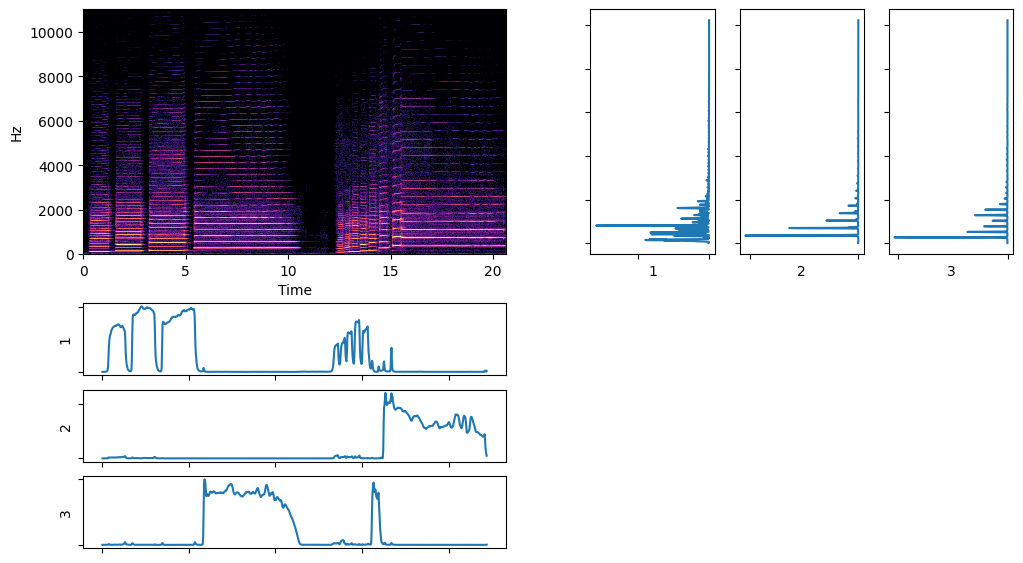

In [264]:
beta_loss='kullback-leibler'

model = NMF(n_components=n_components, init='random', solver='mu', beta_loss=beta_loss)
bases = model.fit_transform(mag_spec)
acts = model.components_
display_components(mag_spec, bases, acts, n_components)

Now we're talking!

If you run the previous cell several times in a row, you'll notice that the order of the components changes. This is a feature (and often a problem) of NMF. Contrary to PCA, the output components are not sorted in any particular order, and their position change due to the random initilization. In matrix factorization this is known as the **permutation problem**. There are special models that try to avoid it, or alternatively one can sort the components a posteriori, for example via feature extraction.



A third popular cost function in NMF, specially in audio, is the **Itakura-Saito (IS) divergence**, which gives the same importance to lower-energy parts of the spectrogram like higher frequencies or transients/attacks, which are as perceptually important as higher energy parts such as sinusoids:

/Users/jjb/Documents/projects/CNMAT/teaching/music30/nov1_lab/code/env_jj_music30/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


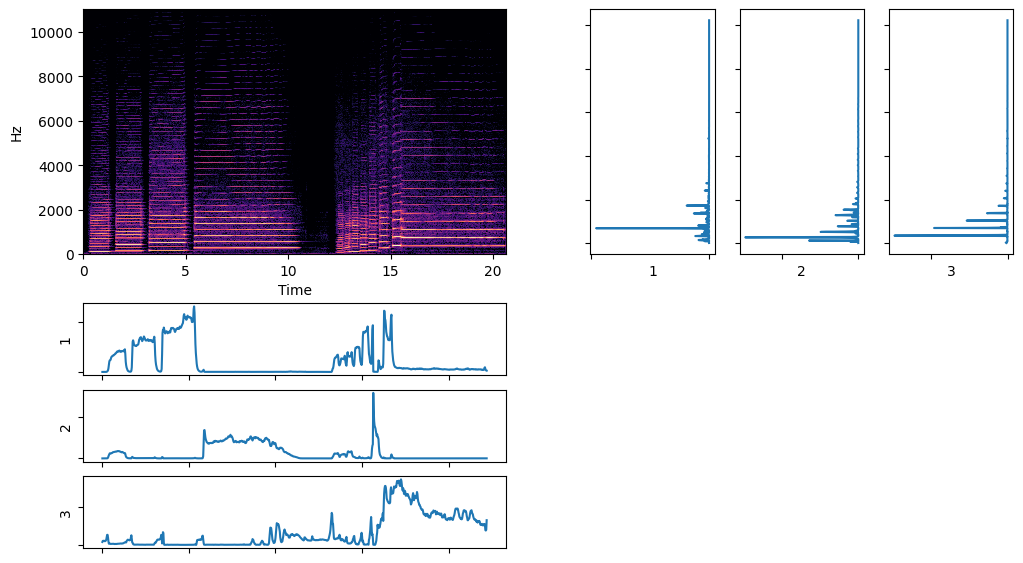

In [265]:
beta_loss='itakura-saito'

model = NMF(n_components=n_components, init='random', solver='mu', beta_loss=beta_loss)
bases = model.fit_transform(mag_spec)
acts = model.components_
display_components(mag_spec, bases, acts, n_components)

What's happening under the hood is actually pretty simple. We saw in the lecture that the trick of using adaptive learning rates to enforce non-negativity produces a set of 2 **multiplicative update (MU) rules** for block-coordinate descent (in this case, corresponding to the KL divergence):

\begin{equation}
\mathbf{W} \leftarrow \mathbf{W} \circ \frac{\frac{\mathbf{X}}{\mathbf{WH}}\mathbf{H}^T}{\mathbf{1H}^T}
\end{equation}
\begin{equation}
\mathbf{H} \leftarrow \mathbf{H} \circ \frac{\mathbf{W}^T\frac{\mathbf{X}}{\mathbf{WH}}}{\mathbf{W}^T\mathbf{1}}
\end{equation}

The $\circ$ symbols means the Hadamard product (element-by-element product), and the division is also element-by-element. $T$ means transpose (flip around the diagonal). The $\mathbf{1}$ symbols denote a unit diagonal matrix (with only ones at its diagonal). So these rules, together with a random initilization of the matrices, translate to the following lines of Python code:

In [266]:
def kl_nmf(X, k=10, it=100):

    nr = X.shape[0]
    nc = X.shape[1]

    # random init
    H = np.random.randn(k, nc)
    W = np.random.randn(nr, k)
    np.abs(W, W)
    np.abs(H, H)
    
    I = np.ones([nr,nc])                  # unit diagonal matrix
    for i in range(it):
        
        # update W
        WH = np.dot(W,H)                  # np.dot is the matrix product
        N = np.dot(np.divide(X,WH),H.T)   # np.divide is the element-by-element division
        P = np.dot(I,H.T)
        W *= np.divide(N,P)               # *= is the Hadamard product
        
        #update H
        WH = np.dot(W,H)
        N = np.dot(W.T,np.divide(X,WH))
        P = np.dot(W.T,I)
        H *= np.divide(N,P)

    return W,H

We have coded a full implementation of KL-NMF, so let's run that!

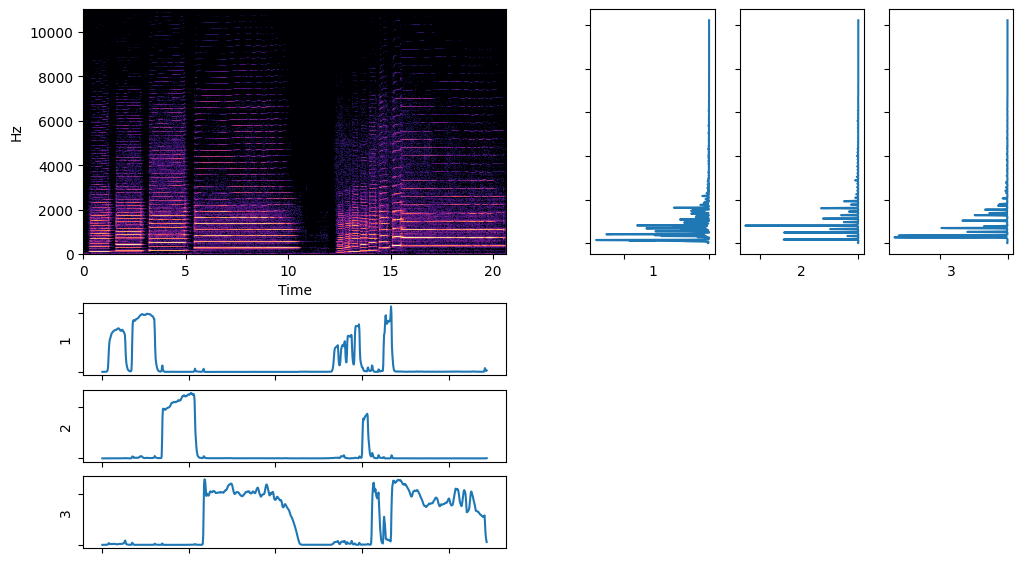

In [267]:
bases, acts = kl_nmf(mag_spec, k=n_components)
display_components(mag_spec, bases, acts, n_components)

There are still some differences as compared to the scikit-learn implementation, mainly due to some subtleties in the random initialization.

You can now experiment with any sound, different number of components, and different cost functions!

Do you identify any trend, or special behaviours? Let me know!

# Section 3: Wiener resynthesis

Until now we have decomposed and visually inspected the components. Let's make some sounds with them!

To do that, we need to:
1. Generate a time-frequency layer by modulating a spectral base with a temporal activation
2. Compute a Wiener mask from the time-frequency layer
3. Apply the Wiener mask to the input sound
4. Invert the resulting spectrogram

Run the following cell multiple times setting different base and activation indices (first index is 1). If act_index = base_index, you are reconstituting original components that were present in the original sound. If act_index $\neq$ base_index, you are creating new sounds!

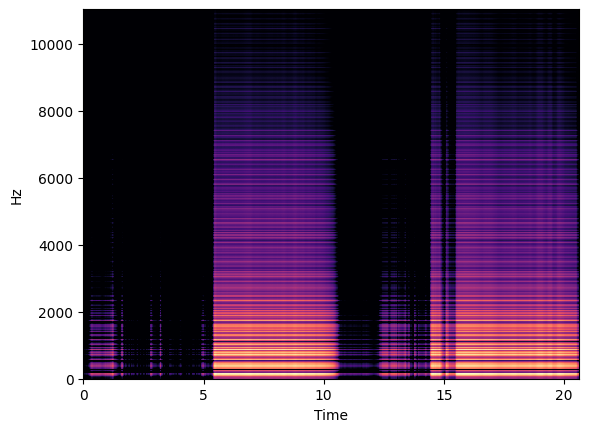

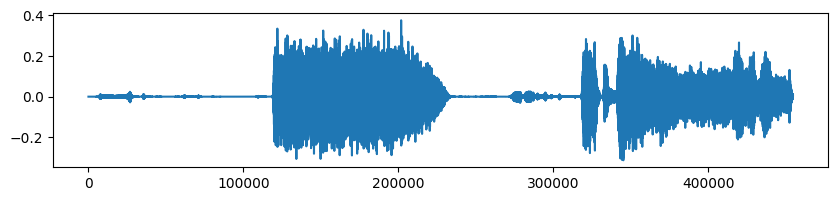

In [269]:
# generate and display a component layer
base_index = 1
act_index = 3
layer = np.outer(bases[:,base_index-1], acts[act_index-1,:])  # outer product to generate a layer
librosa.display.specshow(librosa.amplitude_to_db(layer, ref=np.max), x_axis='time', y_axis='linear')
plt.show()

# compute the Wiener mask
mask = np.divide(layer,np.dot(bases,acts)+0.01)  # add a small value to avoid large peaks

# apply the mask to the complex input spectrogram
filtered_spec = mask * spec

# invert the spectrogram (inverse Short Time Fourier Transform)
out_wav = librosa.istft(filtered_spec)

# normalize between -1 and 1 just in case
if np.max(out_wav) > 1.0:
    out_wav /= np.max(np.abs(out_wav))

# plot and playback the output waveform
plt.figure(figsize=(10,2))
plt.plot(out_wav)
plt.show()
Audio(out_wav, rate=sr)
